# Activity Prediction Using Time Series
The project is based off of the dataset [
WISDM Smartphone and Smartwatch Activity and Biometrics](http://archive.ics.uci.edu/ml/datasets/WISDM+Smartphone+and+Smartwatch+Activity+and+Biometrics+Dataset+), taken from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php). The goal is to use sensor measurements from accelerometers and gyroscopes on smart phones and smart watches to predict a particular activity, such as walking, jogging, or standing.

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

import utilities.constants as con
import utilities.methods as met

%matplotlib inline

In [2]:
print(f'Using TensorFlow version {tf.__version__}.')

Using TensorFlow version 2.0.0.


## Map Activities

In [3]:
met.map_activities()

## Load Dataset
Let's first take a look at an example file from the dataset.

In [4]:
sensor_files = met.create_file_list('phone', 'accel')

In [5]:
df_concat = met.load_data(sensor_files)

/Users/dave/anaconda3/envs/py_36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


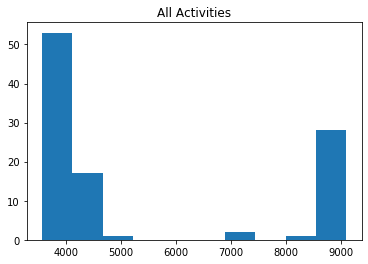

In [6]:
data_lengths = np.array([len(x) for x in con.DATA_DICT['dfs']])
plt.hist(data_lengths)
plt.title('All Activities')
plt.show()

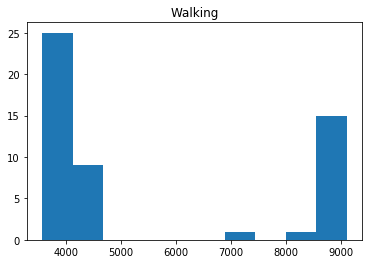

Mean length: 5486.608


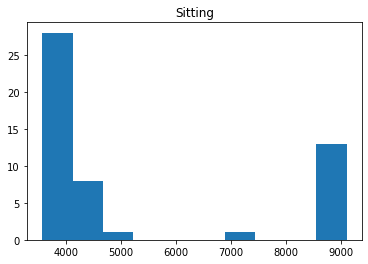

Mean length: 5188.078


In [7]:
for i in range(len(con.ACTIVITY_LIST)):
    data_lengths = np.array([(len(x), y)[0] for x, y in zip(con.DATA_DICT['dfs'], con.DATA_DICT['labels']) if y == i])
    plt.hist(data_lengths)
    plt.title(con.ACTIVITY_LIST[i].title())
    plt.show()
    print(f'Mean length: {data_lengths.mean():0.3f}')

## Create Features

In [8]:
X = met.create_features(5000)

In [9]:
y = np.array(con.DATA_DICT['labels'])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [11]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(91, 5000, 3) (11, 5000, 3) (91,) (11,)


In [12]:
# y_train_one_hot = to_categorical(y_train, num_classes=2)
# y_test_one_hot = to_categorical(y_test, num_classes=2)

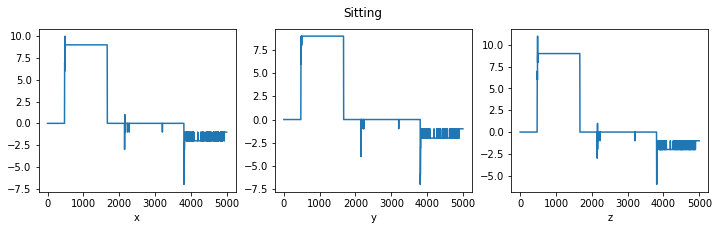

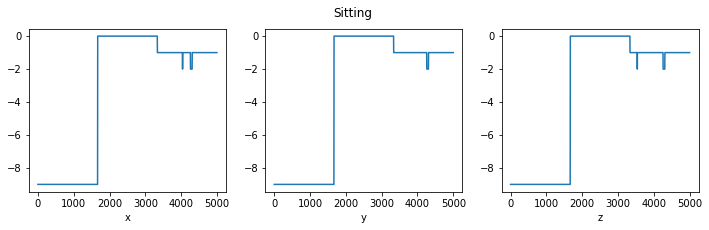

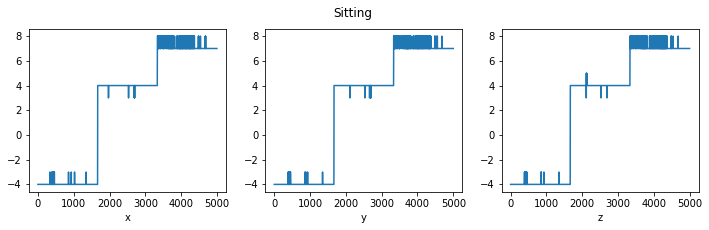

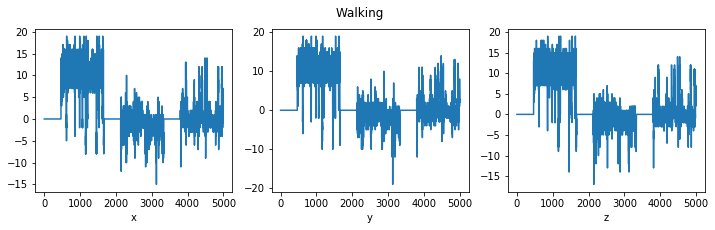

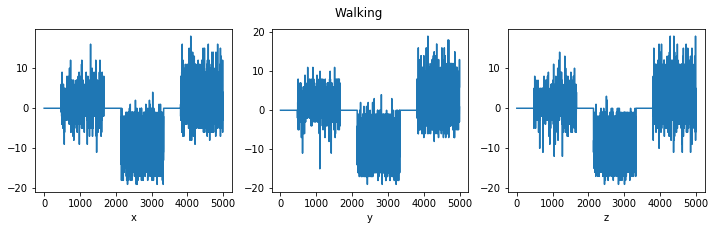

In [13]:
orientation = ['x', 'y', 'z']
for i in range(5):
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    plt.suptitle(con.ACTIVITY_LIST[y_train[i]].title())
    for j in range(X_train.shape[2]):
        ax[j].plot(X_train[i, :, j])
        ax[j].set_xlabel(orientation[j])
    plt.show()

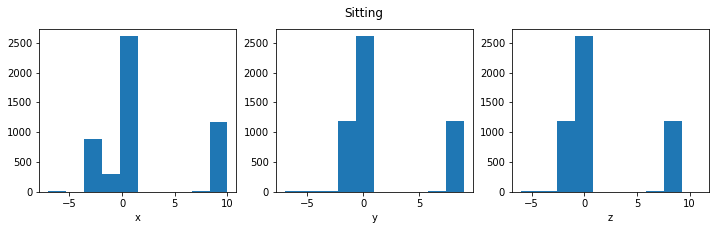

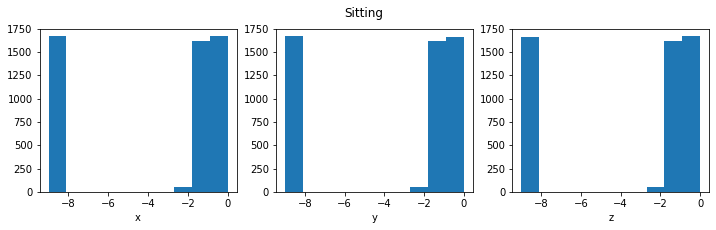

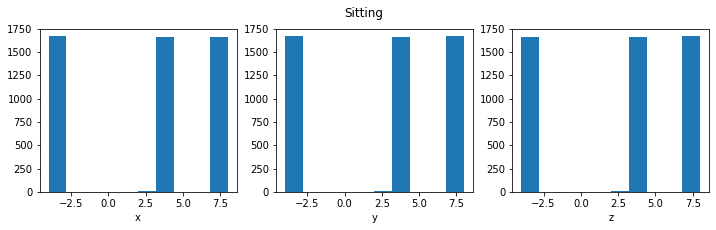

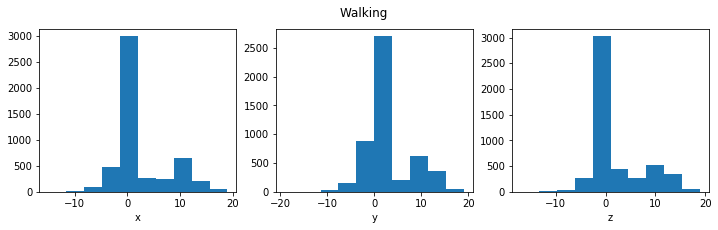

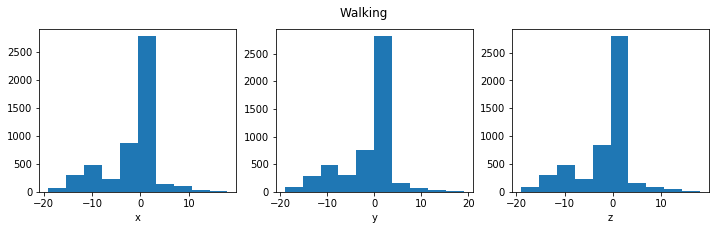

In [14]:
orientation = ['x', 'y', 'z']
for i in range(5):
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    plt.suptitle(con.ACTIVITY_LIST[y_train[i]].title())
    for j in range(X_train.shape[2]):
        ax[j].hist(X_train[i, :, j])
        ax[j].set_xlabel(orientation[j])
    plt.show()

In [15]:
for i in range(len(np.unique(y_test))):
    print(f'There are {len(y_test[y_test == i])} values for {con.ACTIVITY_LIST[i]} in the test set.')

There are 8 values for walking in the test set.
There are 3 values for sitting in the test set.


## Normalization
Normalize the time series, so all values are between 0 and 1. Since the time series distributions do not appear normal, normalization will perform better than standardization.

In [16]:
X_train_normalized = np.zeros(X_train.shape)
X_test_normalized = np.zeros(X_test.shape)
for i in range(X_train.shape[2]):
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train_2d = X_train[:, :, i].reshape(X_train.shape[0]*X_train.shape[1], 1)
    X_test_2d = X_test[:, :, i].reshape(X_test.shape[0]*X_test.shape[1], 1)
    scaler.fit(X_train_2d)
    X_train_temp = scaler.transform(X_train_2d)
    X_test_temp = scaler.transform(X_test_2d)
    X_train_normalized[:, :, i] = X_train_temp.reshape(X_train.shape[0], X_train.shape[1])
    X_test_normalized[:, :, i] = X_test_temp.reshape(X_test.shape[0], X_test.shape[1])

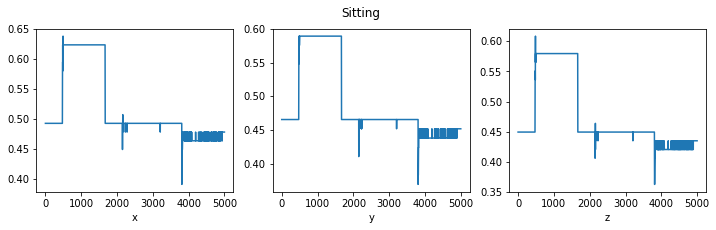

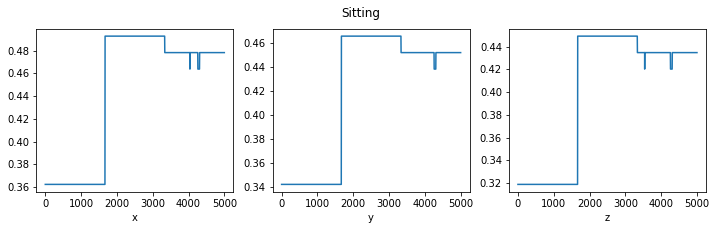

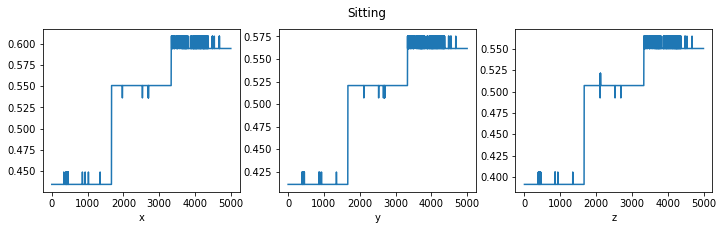

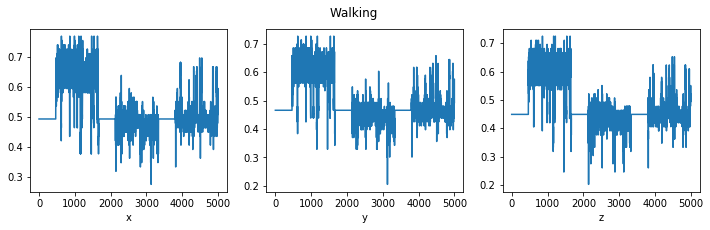

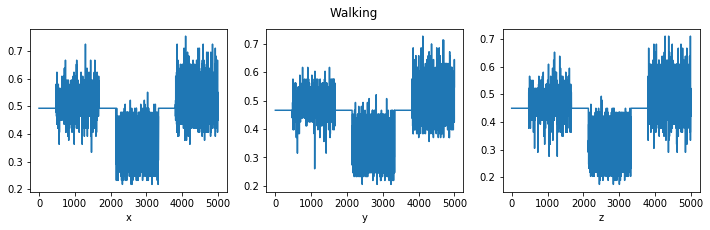

In [17]:
orientation = ['x', 'y', 'z']
for i in range(5):
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    plt.suptitle(con.ACTIVITY_LIST[y_train[i]].title())
    for j in range(X_train_normalized.shape[2]):
        ax[j].plot(X_train_normalized[i, :, j])
        ax[j].set_xlabel(orientation[j])
    plt.show()

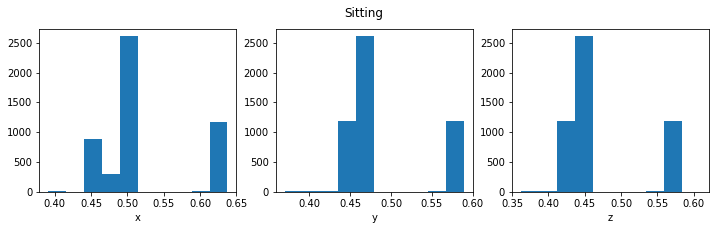

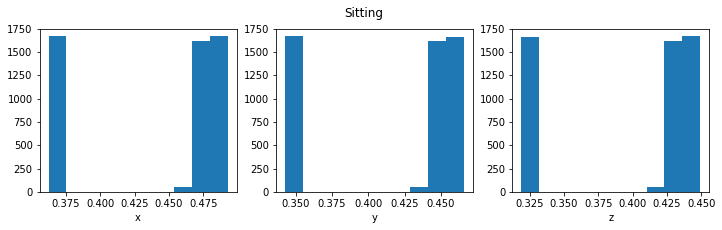

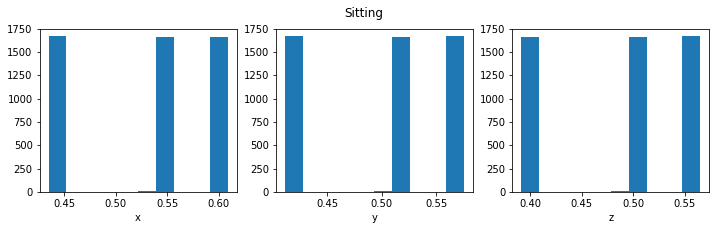

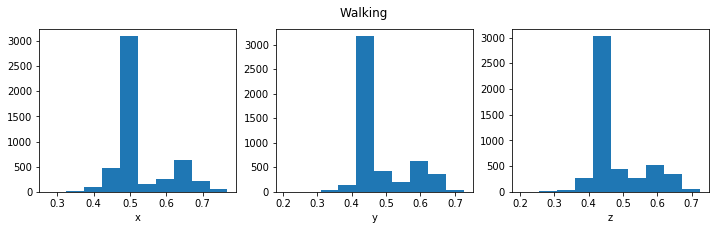

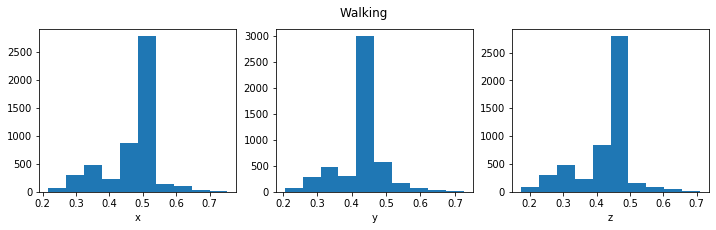

In [18]:
orientation = ['x', 'y', 'z']
for i in range(5):
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    plt.suptitle(con.ACTIVITY_LIST[y_train[i]].title())
    for j in range(X_train_normalized.shape[2]):
        ax[j].hist(X_train_normalized[i, :, j])
        ax[j].set_xlabel(orientation[j])
    plt.show()

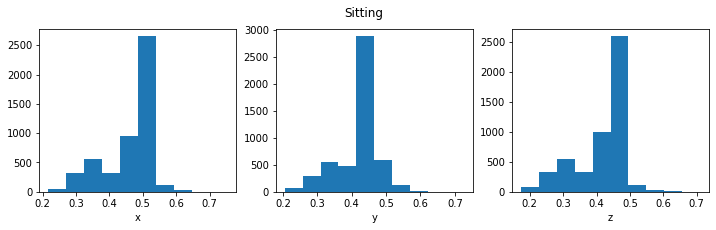

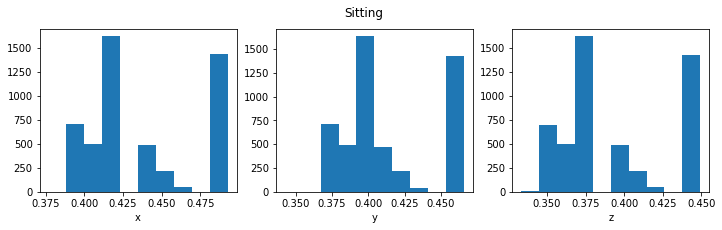

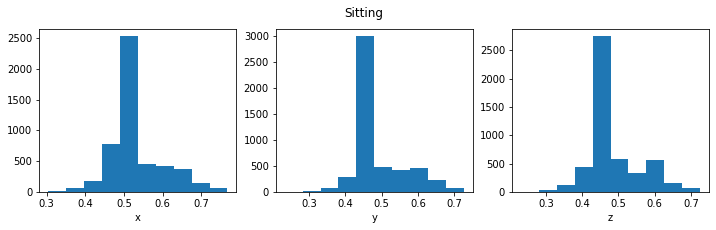

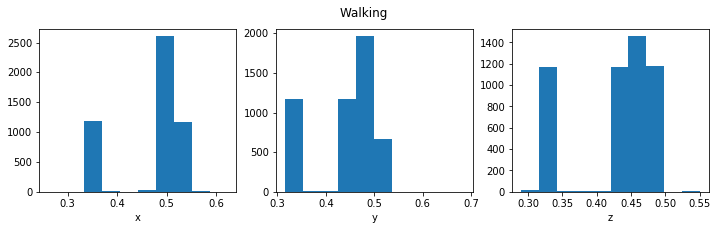

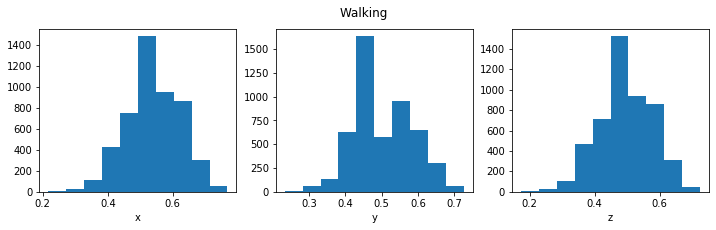

In [19]:
orientation = ['x', 'y', 'z']
for i in range(5):
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    plt.suptitle(con.ACTIVITY_LIST[y_train[i]].title())
    for j in range(X_test_normalized.shape[2]):
        ax[j].hist(X_test_normalized[i, :, j])
        ax[j].set_xlabel(orientation[j])
    plt.show()

In [20]:
X_train_normalized.shape

(91, 5000, 3)

In [42]:
model = Sequential([
    Flatten(input_shape=(5000, 3)),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(2, activation='softmax')
])

In [43]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [44]:
model.fit(X_train_normalized, y_train, epochs=20)

Train on 91 samples
Epoch 1/20
91/91 [==============================] - 1s 11ms/sample - loss: 7.6154 - accuracy: 0.5934
Epoch 2/20
91/91 [==============================] - 0s 5ms/sample - loss: 5.6296 - accuracy: 0.5824
Epoch 3/20
91/91 [==============================] - 0s 5ms/sample - loss: 2.7494 - accuracy: 0.5604
Epoch 4/20
91/91 [==============================] - 0s 5ms/sample - loss: 1.8796 - accuracy: 0.5714
Epoch 5/20
91/91 [==============================] - 0s 5ms/sample - loss: 1.2534 - accuracy: 0.5495
Epoch 6/20
91/91 [==============================] - 0s 5ms/sample - loss: 1.8458 - accuracy: 0.4066
Epoch 7/20
91/91 [==============================] - 0s 5ms/sample - loss: 1.2105 - accuracy: 0.5165
Epoch 8/20
91/91 [==============================] - 0s 5ms/sample - loss: 0.9039 - accuracy: 0.5275
Epoch 9/20
91/91 [==============================] - 1s 6ms/sample - loss: 0.7435 - accuracy: 0.5934
Epoch 10/20
91/91 [==============================] - 0s 5ms/sample - loss: 0.81

In [45]:
model.evaluate(X_test_normalized, y_test, verbose=2)

11/1 - 0s - loss: 0.8842 - accuracy: 0.2727


[0.8842251300811768, 0.27272728]